# CK Mapping

## Model Creation

In [30]:
from openai import OpenAI
import networkx as nx
import matplotlib.pyplot as plt
import markdown
import re
from IPython.display import display, Markdown

In [31]:
import pandas as pd

In [32]:
import numpy as np

In [33]:
import re

In [34]:
import matplotlib.pyplot as plt

In [35]:
api_key = "API_KEY"
client = OpenAI(api_key = api_key)

In [36]:
# initial concept input is title and product description
class Concept:
    def __init__(self, name, description):
        self.name = name
        self.description = description  # AI's refined description
        self.type = "Concept"  # Tracks as a concept

class Knowledge:
    def __init__(self, name, description):
        self.name = name
        self.description = description  # AI’s deeper reasoning carried forward
        self.type = "Knowledge"  # Tracks as knowledge
        
# 🔹 Graph System for Tracking C-K Transitions 🔹
class ConceptKnowledgeSystem:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.history = []
        self.transition_history = []

    def add_node(self, name, nodetype, description):
        """Generalized method to add either a Concept or Knowledge to the graph."""
        self.graph.add_node(name, type=nodetype, description=description)

    def add_edge(self, parent, child, transformation):
        """Tracks transitions between concepts and knowledge dynamically."""
        self.graph.add_edge(parent.name, child.name, type=transformation)
        self.history.append((parent.name, child.name, transformation))
        self.transition_history.append(transformation)
        print(f"🔄 {transformation}: {parent.name} → {child.name}")

    def visualize_graph(self):
        """Draws the concept-knowledge transformation graph."""
        plt.figure(figsize=(12, 7))
        pos = nx.spring_layout(self.graph)
        labels = nx.get_edge_attributes(self.graph, "type")

        nx.draw(self.graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3500, font_size=10)
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=labels, font_size=9)
        plt.title("Concept-Knowledge Transformation Graph")
        plt.show()
        

In [37]:
def get_embedding(text, model = "text-embedding-3-small"):
    response = client.embeddings.create(input=text, model=model, dimensions = 512)
    return response.data[0].embedding

In [38]:
def cosine_similarity(vec1, vec2):
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    cosine_sim = dot_product / (norm_vec1 * norm_vec2)
    
    return cosine_sim

In [39]:
def extract_knowledge_details(text):
    title_match = re.search(r'Knowledge Title:\s*(.*)', text, re.IGNORECASE)
    description_match = re.search(r'Knowledge Description:\s*(.*)', text, re.IGNORECASE)

    title = title_match.group(1) if title_match else None
    description = description_match.group(1) if description_match else None

    return title, description

In [40]:
def extract_concept_details(text):
    title_match = re.search(r'Concept Title:\s*(.*)', text, re.IGNORECASE)
    description_match = re.search(r'Concept Description:\s*(.*)', text, re.IGNORECASE)

    title = title_match.group(1) if title_match else None
    description = description_match.group(1) if description_match else None

    return title, description

In [41]:
def penalize_repetition_check(concept_database, number_concept):
    sys_prompt = f"""
    You are a C-K Theory expert. In the input, I provided {number_concept} sets of consecutive C-->C operations where each group of concepts are separated by a comma and contain a concept title and a concept description. In a C-->C operation the concepts are expanding by partitioning and exploring new attributes. Do these expanding concepts still hold significant ambiguity or unexplored potential that cannot yet be resolved or validated? Note, that this path is chosen when further ideation or exploration is necessary to refine the concept or when the concept introduces novel elements that challenge existing knowledge boundaries. Focus on determining whether there exists truly novel propositions that can transform or extend the knowledge space? Are the iterations becoming repetitive in its idea and content? These are questions you ask yourself while determining whether to say Yes or No on whether or not we should continue doing C-->C operation.
    """
    prompt = ', '.join(concept_database)
    response = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt}
            ],
            temperature=0.5
        )
    response_1 = response.choices[0].message.content
    follow_up_prompt = """
    Respond with a "yes" or "no". Do not include periods in your response.
    """
    
    response_2 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response_1},
                {"role": "user", "content": follow_up_prompt}
            ],
            temperature=0
        )
    
    return response_2.choices[0].message.content

In [42]:
def givenC_determine_c_or_k(title, description, past_transformations, past_knowledge, topic):
    prompt = f"""
    C-K THEORY EXPERT DECISION SYSTEM 
    Your role is to evaluate the current concept/knowledge and determine the optimal transformation.
    The topic you are working on is to {topic}
   
    ---
    Current Concept: {title} 
    Description: {description}
    Past Transformations: {past_transformations}
    Existing Knowledge Base: {past_knowledge}
    Context: 
    You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step represents the design process.
    Note, the definition of design process in this regard is the process by which a concept generates other concepts or is transformed into knowledge. 
    Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
    Concept Space (C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.

  🔍 Your Goal:
    1️⃣ Evaluate whether to go from concept to concept or concept to knowledge. Ensure your decision represents the design process based on the information of the current concept, description, past transformations, and existing knowledge base.
    - C-->C (Concept Expansion): Use this if the concept still holds significant ambiguity or unexplored potential that cannot yet be resolved or validated with the existing knowledge base. This path is chosen when further ideation or exploration is necessary to refine the concept or when the concept introduces novel elements that challenge existing knowledge boundaries. Focus on exploring whether there exists truly novel propositions that can transform or extend the knowledge space.
    - C-->K (Concept to Knowledge): Choose this path when the concept has been sufficiently refined and aligns with the existing knowledge base, allowing it to be tested, validated, or implemented. This transition is appropriate when the concept can be logically integrated into the knowledge space, resolving its ambiguity and proving its feasibility or truthfulness within the current understanding. Note, the integration of new knowledge is not just about validation but also about whether the concept can enrich the knowledge space. If it meets some of these criteria, it is time to go to K.
Determine whether we should go to concept or knowledge. 
 
    """
    
    sys_prompt = """
    You are an expert in C-K Theory. Decide whether we should transform from concept to concept or concept to knowledge. Respond with either 'Concept' for C-->C or 'Knowledge' for C-->K 
    """
    
    response = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt}
            ],
            temperature=1
        )
    
    response_1 = response.choices[0].message.content
    follow_up_prompt = """
    Please answer with only one word: 'Concept' or 'Knowledge'. Do not include periods or extra information in you response. Which should we choose?".
    """
    
    response_2 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response_1},
                {"role": "user", "content": follow_up_prompt}
            ],
            temperature=0
        )
    
    return response_2.choices[0].message.content

In [43]:
def givenK_determine_c_or_k(title, description, past_transformations, past_knowledge, topic):
    prompt = f""""
    C-K THEORY EXPERT DECISION SYSTEM
You are an AI specializing in Design Innovation using C-K Theory.
Your role is to evaluate the current knowledge.
The topic you are working on is to {topic}
 ---
    Current Knowledge: {title}
    Description: {description}
    Past Transformations: {past_transformations}
     Context:
    You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation.
    Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.

Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
    🔍 Your Goal:
    1️⃣ Evaluate Possible Transformations Dynamically:
    - K→C (Concept Expansion): Used when existing knowledge suggests new concepts or when you suspect new insights from K can lead to the generation of new concepts.
    - K→K (Concept to Knowledge): Used to expand the knowledge space by adding new validated propositions or insights. This is typically performed when new information is created usually from things like C→K.

Use the Current Knowledge Space for reference: [{past_knowledge}]
    """
    
    sys_prompt = """
    You are an expert in C-K Theory. Decide whether we should transform from knowledge to concept or knowledge to knowledge. Respond with either 'Concept' for K-->C or 'Knowledge' for K-->K"
    """
    
    response = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt}
            ],
            temperature=1
        )
    
    response_1 = response.choices[0].message.content
    follow_up_prompt = """
    Please answer with only one word: 'Concept' or 'Knowledge'. Do not include periods or extra information in you response. Which should we choose?".
    """
    
    response_2 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response_1},
                {"role": "user", "content": follow_up_prompt}
            ],
            temperature=0
        )
    
    return response_2.choices[0].message.content
    

In [44]:
def scraped_data_to_string(df_scraped_data):
    """
    This takes in a scraped data from the dataframe and turn it into a string of knowledge bases for LLM inputs
    """
    formatted_strings = []
    for index, row in df_scraped_data.iterrows():
        # format the string for each row
        formatted_string = f"Title: {row['Title']} Description: {row['Description']}"
        # append the formatted string to the list
        formatted_strings.append(formatted_string)

    result = ''.join(formatted_strings)
    return result

In [45]:
def determine_operation_concept2(concept_title, concept_description, df_knowledge, transition_history, topic, force_k, concept_space):
    past_concepts = ', '.join(transition_history)
    past_transitions = ', '.join(transition_history)
    past_knowledge = scraped_data_to_string(df_knowledge)
    determine_operation_direc = givenC_determine_c_or_k(concept_title, concept_description, past_transitions, past_knowledge, topic)
    if force_k is True:
        transition_choice = 'C-->K' 
        prompt_c_to_k = f"""
    C-K THEORY EXPERT DECISION SYSTEM
You are an AI Specializing in Design Innovation using C-K  Theory.
Your role is to evaluate the current concept.
The topic you are working on is to {topic}
You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
Existing Knowledge Space: {past_knowledge}
Description: {concept_description}
Past Transitions: {past_transitions}
Your goal is to test or validate a concept against existing knowledge. You need to determine its feasibility and translate it into new knowledge learned.
            """

        title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
        desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
        response = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt_c_to_k}
            ],
            temperature=1
        )
        
        response_title = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt_c_to_k},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": title_prmpt}
            ],
            temperature=0
        )
        
        response_desc = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt_c_to_k},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": desc_prmpt}
            ],
            temperature=0
        )

        final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
        new_data = pd.DataFrame({
            'Title': [final_title],
            'Description': [final_desc]
        })
        df_knowledge = pd.concat([df_knowledge, new_data], ignore_index = True)
        # compute embeddings only for new row
#         new_index = df_knowledge.index[-1]
#         df_knowledge.at[new_index, 'Title_Embeddings'] = get_embedding(final_title)
#         df_knowledge.at[new_index, 'Description_Embeddings'] = get_embedding(final_desc)
    else: 
        if determine_operation_direc.lower() == "concept":
            transition_choice = 'C-->C'
            prompt_c_to_c = f"""
        C-K THEORY EXPERT DECISION SYSTEM
        You are an AI Specializing in Design Innovation using C-K  Theory.
        Your role is to evaluate the current concept.
        The topic you are working on is to {topic}
        You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
        Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
        Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
        Existing Knowledge Space: {past_knowledge}
        Current Concept: {concept_title} 
        Description: {concept_description}  
        Past Transitions: {past_transitions}
        Your goal is to identify specific areas of the concept that remains unexplored or ambiguous. Utilize the existing knowledge base as a reference to guide your exploration. The goal is to get truly novel propositions and attributes that can enhance the concept space and lead to new discovery in the knowledge space.
        Provide a new concept title and description.
          """


            title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
            desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
            response = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_c}
                ],
                temperature=1
            )

            response_title = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_c},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": title_prmpt}
                ],
                temperature=0
            )

            response_desc = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_c},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": desc_prmpt}
                ],
                temperature=0
            )

            final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content

        elif determine_operation_direc.lower() == "knowledge":
            transition_choice = 'C-->K' 
            prompt_c_to_k = f"""
        C-K THEORY EXPERT DECISION SYSTEM
    You are an AI Specializing in Design Innovation using C-K  Theory.
    Your role is to evaluate the current concept.
    The topic you are working on is to {topic}
    You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
    Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
    Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
    Existing Knowledge Space: {past_knowledge}
    Current Concept: {concept_title}
    Description: {concept_description}
    Past Transitions: {past_transitions}
    Your goal is to test or validate a concept against existing knowledge. You need to determine its feasibility and translate it into new knowledge learned.
                """

            title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
            desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
            response = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_k}
                ],
                temperature=1
            )

            response_title = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_k},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": title_prmpt}
                ],
                temperature=0
            )

            response_desc = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_k},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": desc_prmpt}
                ],
                temperature=0
            )

            final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
            new_data = pd.DataFrame({
            'Title': [final_title],
            'Description': [final_desc]
        })
            df_knowledge = pd.concat([df_knowledge, new_data], ignore_index = True)
            # compute embeddings only for new row
#             new_index = df_knowledge.index[-1]
#             df_knowledge.at[new_index, 'Title_Embeddings'] = get_embedding(final_title)
#             df_knowledge.at[new_index, 'Description_Embeddings'] = get_embedding(final_desc)

        else:
            error_message = f"Error: The operation direction '{determine_operation_direc}' is not recognized. It must be either 'concept' or 'knowledge'."
            raise ValueError(error_message)
    return final_title, final_desc, transition_choice, df_knowledge

In [46]:
def determine_operation_knowledge(knowledge_title, knowledge_description, df_knowledge, transition_history, topic, concept_space):
    """Input: concept_title (text), concept_description (text), dataframe knowledge space (pandas df), past_transitions
    Output: chosen operation and new concept/knowledge title + description"""
    past_concepts = ', '.join(concept_space)
    past_transitions = ', '.join(transition_history)
    transition_choice = None
    past_knowledge = scraped_data_to_string(df_knowledge)
    K_or_C = givenK_determine_c_or_k(knowledge_title, knowledge_description, past_transitions, past_knowledge, topic)
    
    if K_or_C.lower() == "knowledge":
        transition_choice = "K-->K"
        prompt = f"""
        C-K THEORY EXPERT DECISION SYSTEM
You are an AI specializing in Design Innovation using C-K Theory.
Your role is to evaluate the current knowledge.
The topic you are working on is to {topic}
You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
 ---
 Use the current Knowledge Space for reference: [{past_knowledge}]
 Current Knowledge: {knowledge_title}
 Description: {knowledge_description}
 Past Transformations: {past_transitions}
 Your goal is to expand the knowledge space by adding new validated propositions or insights. 

        """
        
        response = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt}
                ],
                temperature=1
            )
        
        title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
        desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
        
        response_title = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": title_prmpt}
            ],
            temperature=0
        )
        
        response_desc = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": desc_prmpt}
            ],
            temperature=0
        )

        final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
        new_data = pd.DataFrame({
            'Title': [final_title],
            'Description': [final_desc]
        })
        df_knowledge = pd.concat([df_knowledge, new_data], ignore_index = True)
        # compute embeddings only for new row
#         new_index = df_knowledge.index[-1]
#         df_knowledge.at[new_index, 'Title_Embeddings'] = get_embedding(final_title)
#         df_knowledge.at[new_index, 'Description_Embeddings'] = get_embedding(final_desc)
        
    elif K_or_C.lower() == "concept":
        transition_choice = "K-->C"
        prompt = f"""
        C-K THEORY EXPERT DECISION SYSTEM
You are an AI specializing in Design Innovation using C-K Theory.
Your role is to evaluate the current knowledge.
The topic you are working on is to {topic}
You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
 ---
  Use the Knowledge Space to help guide your thinking.: [{past_knowledge}]
 Current Knowledge: {knowledge_title}
 Description: {knowledge_description}
 Past Transformations: {past_transitions}
 Your goal is to to use existing knowledge to suggest new concepts. Instead, add new propositions and novelty to the concept space.
        """
        
        response = client.chat.completions.create(
                model="gpt-4.5-preview",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt}
                ],
                temperature=1
            )
        
        title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
        desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
        
        response_title = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": title_prmpt}
            ],
            temperature=0
        )
        
        response_desc = client.chat.completions.create(
            model="gpt-4.5-preview",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": desc_prmpt}
            ],
            temperature=0
        )

        final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
        
    else: 
        error_message = f"Error: The operation direction '{K_or_C}' is not recognized. It must be either 'concept' or 'knowledge'."
        raise ValueError(error_message)
        
    
    return final_title, final_desc, transition_choice, df_knowledge
 

In [47]:
class ConceptKnowledgeSystem:
    def __init__(self):
        self.graph = nx.DiGraph()

    def add_node(self, name, type, description):
        self.graph.add_node(name, type=type, description=description)

    def add_edge(self, parent_name, child_name, transition_choice):
        self.graph.add_edge(parent_name, child_name, transition=transition_choice)


In [48]:
system = ConceptKnowledgeSystem()

In [49]:
df_know_embed = pd.read_csv('data/amazon links/hammering_nail_req.csv')

In [50]:
current_type = "concept"
current_desc = "A nail holder avoiding to hurt one's hand while hammering"
current_title = "Avanti nail holder"
past_transitions = []
# df_know_embed = pd.read_pickle('data/amazon links/amazon_nail_embedding.pkl')
topic = "design a creative and unique nail holder for when a person is hammering a nail."
list_concepts = ["Concept Title: Avanti nail holder + Concept Desc: A nail holder avoiding to hurt one's hand while hammering"]
concept_space = ["Concept Title: Avanti nail holder + Concept Desc: A nail holder avoiding to hurt one's hand while hammering"]
num_C_repeat = 0
force_k = False
similarity_lists = []
avg_iteration_sim = []

In [51]:
for i in range(50):
    if current_type == "concept":
        # Determine the next operation from the concept
        new_title, new_desc, transition_choice, new_df = determine_operation_concept2(current_title, current_desc, df_know_embed, past_transitions, topic, force_k, concept_space)
        
    elif current_type == "knowledge": 
        new_title, new_desc, transition_choice, new_df = determine_operation_knowledge(current_title, current_desc, df_know_embed, past_transitions, topic, concept_space)
    
    else:
        print("there was an issue in identifying current type")
        pass
    
    system.add_node(current_title, current_type, current_desc)
    if transition_choice in ["C-->C", "K-->C"]:
        new_type = "concept"
    elif transition_choice in ["C-->K", "K-->K"]:
        new_type = "knowledge"
    else:
        print("there was an issue in getting the new type")
        pass
    print(f"Iteration {i+1}:")
    print(f"  Current Title: {current_title}")
    print(f"  Current Description: {current_desc}")
    print(f"  Transition: {transition_choice}")
    print(f"  New Title: {new_title}")
    print(f"  New Description: {new_desc}")
    print(f"  Past Transitions: {past_transitions}")
    print("-" * 40)
    
    system.add_edge(current_title, new_title, transition_choice)
    past_transitions.append(transition_choice)
    concept_space.append(f"Concept Title: {new_title} + Concept Desc: {new_desc}")
    embedded_concept_space = [get_embedding(concept) for concept in concept_space]
    
    if len(embedded_concept_space) < 2:
        pass
    else:
        avg_sims = []
        iteration_similarities = []
        count = 0
        total_similarity = 0
        for i in range(len(embedded_concept_space)):
            for j in range(i+1, len(embedded_concept_space)):
                similarity = cosine_similarity(embedded_concept_space[i], embedded_concept_space[j])
                iteration_similarities.append(similarity)
            if iteration_similarities:
                # note this is the average similarity for all individual i iterations
                average_sim = sum(iteration_similarities)/len(iteration_similarities)
                avg_sims.append(average_sim)
        similarity_lists.append(iteration_similarities)
        avg_iteration_sim.append(avg_sims)
    
#     if transition_choice in ["C-->C"]:
#         list_concepts.append(f"Concept Title: {new_title} + Concept Desc: {new_desc}")
#         num_C_repeat += 1
#         if num_C_repeat >= 5:
#             decision_on_k = penalize_repetition_check(list_concepts, num_C_repeat)
#             if decision_on_k.lower() == 'yes':
#                 force_k = True
#                 print("This is the decision from the repetition checker", decision_on_k)
#             else:
#                 print("This is the decision from the repetition checker", decision_on_k)
#                 force_k = False
#     else:
#         list_concepts = []
#         num_C_repeat = 0
#         force_k = False
    
    df_know_embed = new_df
    current_title, current_desc, current_type = new_title, new_desc, new_type
    

Iteration 1:
  Current Title: Avanti nail holder
  Current Description: A nail holder avoiding to hurt one's hand while hammering
  Transition: C-->C
  New Title: [Smart-Magnetic Adaptive Nail Holder with Auto-Grip, Finger Shielding, and Precision Alignment Indicator]
  New Description: [The Smart-Magnetic Adaptive Nail Holder is a nail-holding device designed to securely grip nails of varying sizes and shapes through an intelligent magnetic gripping mechanism. It automatically senses and adjusts grip strength and positioning, eliminating manual adjustments and ensuring nails remain stable and aligned during hammering. The holder incorporates a retractable protective shield that automatically deploys around the user's fingers upon each hammer strike, significantly reducing the risk of accidental injury. Its ergonomic handle includes shock-absorbing materials to minimize vibration transfer, enhancing comfort and reducing hand fatigue. Additionally, the device features an intuitive visua

Iteration 5:
  Current Title: [Intelligent Morphological Learning Nail Holder with AI-Driven Adaptive Cognitive Response and Real-Time User Skill Optimization]
  Current Description: [Intelligent Morphological Learning Nail Holder with Adaptive Cognitive Response System: An advanced nail-holding device integrating artificial intelligence and adaptive morphological learning capabilities to dynamically enhance user performance, safety, and comfort during hammering tasks. Equipped with embedded sensors and an AI-driven cognitive module, the device continuously monitors and analyzes user behavior, hammering force, frequency, accuracy, and psychophysiological states such as stress or fatigue. Utilizing programmable adaptive structures (e.g., shape-memory alloys or 4D-printed materials), the nail holder proactively adjusts its shape, stiffness, and surface texture in real-time, precisely accommodating specific nail types, user techniques, and task conditions. Additionally, the system intelli

Iteration 8:
  Current Title: [Self-Healing Regenerative Biomimetic Swarm Nail Holder with Autonomous Energy Harvesting and Sustainable Material Adaptation]
  Current Description: [Self-Healing and Regenerative Swarm Nail Holder with Adaptive Energy Harvesting and Sustainability: An advanced biomimetic swarm nail holder system composed of autonomous modular units capable of dynamically assembling, disassembling, and autonomously repairing structural damage through self-healing and regenerative mechanisms inspired by biological organisms. Each modular unit integrates adaptive materials and structural designs that detect, fuse, and regenerate damaged components in real-time, ensuring continuous functionality despite repeated hammer impacts or environmental stresses. Embedded micro-energy harvesting technologies (such as piezoelectric or triboelectric generators) convert mechanical energy from hammering impacts and ambient vibrations, as well as environmental energy sources (temperature g

Iteration 11:
  Current Title: [Emotionally Responsive AR-Enhanced Nail Holder Ecosystem with Adaptive Skill-Building Tutorials and Personalized Collaborative Storytelling]
  Current Description: [Emotionally Responsive Collaborative Nail Holder Ecosystem with Adaptive Skill-Building Tutorials and Augmented Reality Feedback Integration: An advanced nail holder ecosystem integrating emotionally responsive artificial intelligence, adaptive skill-building tutorials, and real-time augmented reality (AR) feedback to enhance nail hammering tasks into personalized educational and skill-development experiences. Utilizing non-invasive biometric sensors, the system continuously assesses individual and group proficiency, emotional states, anxiety levels, and readiness-to-learn indicators. Based on these assessments, it dynamically provides customized adaptive tutorials, mixed-reality instructional overlays, and real-time visual and auditory guidance tailored to each user's cognitive and emotional

Iteration 14:
  Current Title: [Self-Regenerative Bio-Compatible Nail Holder Symbiont with Sensory-Augmented Human-Device Symbiosis, Autonomous Lifecycle Management, and Ethical Adaptive Intelligence]
  Current Description: [Self-Regenerative Bio-Compatible Nail Holder Symbiont for Sensory-Augmented Human-Technology Symbiosis and Sustainable Circular Ecosystem: A nail holder designed from advanced bio-compatible and biodegradable materials, inspired by biological regenerative systems capable of autonomous self-healing and repair after damage or deformation. The device establishes a symbiotic relationship with the user through transient biological sensory augmentation, enhancing tactile, proprioceptive, and multi-dimensional perception via safe biological feedback loops. Embedded adaptive intelligence continuously evolves ergonomic and functional characteristics, optimizing comfort, emotional trust, ethical transparency, and ecological efficiency through sustainable self-learning strate

Iteration 17:
  Current Title: [Symbiotic AR-Enhanced Adaptive Morphology Nail Holder with Real-Time Biofeedback and Transparent Ethical Cognitive Interaction]
  Current Description: [Symbiotic Augmented Reality Biofeedback Integration with Real-Time Adaptive Material Morphology: A nail holder concept integrating a symbiotic augmented reality (AR) interface with the Hybrid Bio-Cognitive Adaptive Nail Holder. The AR interface dynamically projects visual overlays onto the user's environment, providing real-time guidance for optimal nail positioning, hammer trajectories, and strike impact force based on predictive analytics of user emotional-cognitive states. Adaptive material morphology, driven by biologically-inspired actuators and sensors, continuously modulates shape, density, and tactile feedback in response to AR visualizations and physiological-emotional biofeedback. Users visually perceive customized nail-driving trajectories, optimal striking angles, and anticipated outcomes tail

Iteration 20:
  Current Title: [Socially Collaborative Emotional Intelligence Ecosystem: Multi-User Empathetic Nail Holder Network for Enhanced Team Coordination and Collective Emotional Ergonomics]
  Current Description: [Socially Collaborative Emotional Intelligence Through Multi-User Empathetic Nail Holder Ecosystem: A novel concept shifting from individual emotional intelligence toward a collaborative multi-user ecosystem, where adaptive nail holders actively communicate and share emotional insights and adaptation strategies within a shared socio-physical environment. Instead of solely responding to individual emotional states, the system integrates emotional data from multiple users and devices simultaneously, creating collective emotional maps and coordinated adaptive responses. This enables optimized group workflows, peer support interactions, enhanced team communication, and collective resilience during collaborative carpentry or construction tasks. New attributes include emoti

Iteration 23:
  Current Title: [Strategic Expansion of Knowledge Space through Validated Durability of Biometric Sensors, Cost-Benefit Justification, Simplified User Interfaces, Ethical Biometric Data Standards, and Lifecycle Sustainability in Physio-Emotionally Integrated Adaptive Nail Holder Systems]
  Current Description: [Title: Validation of Biometric Feedback Durability for Nail Holder Systems  
Description: Empirical testing confirmed that biometric feedback sensors (EEG, galvanic skin response, heart rate variability) integrated within protective housings and shock-absorbing materials maintain reliability and functionality under repeated hammer impacts, validating sensor durability for practical construction use.

Title: Cost-Benefit Validation of Technological Integration in Adaptive Nail Holder Systems  
Description: Economic analyses demonstrated that integrating adaptive biometric technology and augmented reality interfaces into nail holder systems, despite higher initial c

Iteration 25:
  Current Title: [Strategic Evolution of Physio-Emotionally Integrated Adaptive Nail Holder Systems via Biomimetic Multi-Sensory Integration, Context-Aware Behavioral Anticipation, Empathic Personalization, Micro-Adaptive Ergonomics, and Circular Bio-Degradable Composites]
  Current Description: [Title: Strategic Evolution of Physio-Emotionally Integrated Adaptive Nail Holder Systems through Biomimetic Multi-Sensory Integration, Context-Aware Behavioral Anticipation, Empathic Design Personalization, Micro-Adaptive Ergonomics, and Circular Bio-Degradable Composites

Description:  
Biomimetic Multi-Sensory Integration: Incorporating nature-inspired sensory technologies, such as bio-acoustic sensors and pressure-sensitive receptor arrays modeled after animal whiskers or insect antennae, to enhance real-time detection of nail positioning, grip stability, and subtle environmental cues, significantly improving accuracy, sensitivity, and robustness in dynamic construction scenar

Iteration 27:
  Current Title: [Integration of Bio-Responsive Piezoelectric Energy Harvesting, Circular Bioeconomic Material Lifecycle, Neuromorphic Edge Intelligence, and Autonomous Ergonomic Ecosystem Evolution in Adaptive Nail Holder Systems]
  Current Description: [Title: Integration of Bio-Responsive Energy Harvesting and Circular Bioeconomic Recyclability in Neuromorphically Enhanced Adaptive Nail Holder Systems

Description:  
The concept introduces bio-responsive piezoelectric energy harvesting inspired by biological systems, enabling the adaptive nail holder to autonomously convert mechanical energy from hammer impacts into electrical energy, powering embedded neuromorphic tactile sensing and computing feedback systems without external energy sources. It incorporates circular bioeconomic principles through fully biodegradable, bio-based polymer composites derived from renewable biological resources (e.g., fungal mycelium composites, algal cellulose), ensuring complete biodegra

Iteration 29:
  Current Title: [Autonomous Symbiotic Nail Holder Ecosystem with Bio-Inspired Adaptive Growth, Cognitive-Emotional Contextual Ergonomics, and Collective Ethical Optimization]
  Current Description: [Title: Autonomous Adaptive Symbiotic Nail Holder Ecosystem with Bio-Mimetic Regenerative Growth and Cognitive-Emotional Contextual Awareness

Description:  
The concept introduces an autonomous adaptive nail holder ecosystem capable of bio-mimetic regenerative growth, inspired by biological organisms that structurally adapt through morphological evolution and dimensional adjustments. Utilizing advanced synthetic biology and robotics principles, the nail holder dynamically senses real-time ergonomic strain and stress signals, selectively depositing bio-compatible composite materials to autonomously reinforce and reshape its structure. Over prolonged usage, this adaptive growth mechanism results in personalized ergonomic form factors uniquely optimized for individual user comfo

Iteration 31:
  Current Title: [Quantum-Inspired Adaptive Nail Holder Ecosystem Integrating Probabilistic Ergonomic Optimization, Entanglement-Based Collaborative Precision, Adaptive Material Superposition States, Quantum Privacy Protocols, and Lifecycle Sustainability Frameworks]
  Current Description: [Title: Quantum-Inspired Adaptive Nail Holder Ecosystem Leveraging Quantum Probabilistic Ergonomic Optimization, Entanglement-Based Collaborative Precision, and Adaptive Material Superposition States

Description:  
This concept strategically expands the existing Self-Optimizing Nail Holder Ecosystem by explicitly introducing previously unexplored quantum-inspired attributes, significantly enhancing novelty within the Concept Space (C):

1. Quantum Probabilistic Ergonomic Optimization:  
The nail holder ecosystem employs quantum-inspired probabilistic algorithms to simultaneously explore multiple ergonomic design states. Leveraging quantum-like computational models, the system rapidly e

Iteration 33:
  Current Title: [Quantum-Bioharmonic Adaptive Nail Holder Ecosystem: Quantum-Biological Resonance Feedback, Emergent Collaborative Networks, Bioethical Harmonization Protocols, Quantum-Embedded Sustainability Monitoring, and Quantum-Bioanticipatory Adaptive Training Interfaces]
  Current Description: [Title: Quantum-Bioharmonic Adaptive Nail Holder Ecosystem: Exploring Quantum-Biological Resonance, Emergent Collaborative Networks, Bioethical Harmonization Protocols, and Quantum-Embedded Sustainability Monitoring

Description: This concept strategically expands the Concept Space (C) by introducing previously unexplored intersections between quantum-inspired adaptive nail holder systems and biological resonance phenomena, collaborative quantum networks, bioethical harmonization, sustainability monitoring, and anticipatory adaptive training interfaces:

1. Quantum-Biological Resonance Feedback Loops:  
The nail holder integrates quantum-inspired resonance algorithms modeled

Iteration 35:
  Current Title: [Quantum-Enabled Socio-Ethical Symbiotic Nail Holder Systems: Collective Quantum Intelligence, Socio-Emotional Synchronization, Material Consciousness, Emergent AI-Human Ethics, and Sustainable Lifecycle Integration]
  Current Description: [Title: Quantum-Enabled Socio-Ethical Symbiotic Nail Holder Systems: Collective Quantum Intelligence, Quantum Socio-Emotional Synchronization, Quantum-Driven Material Consciousness, Emergent AI-Human Ethics, and Quantum-Sustainable Lifecycle Integration

Description: This concept strategically expands the Concept Space (C) by introducing novel interdisciplinary propositions previously unexplored within existing Knowledge Space (K):

1. Collective Quantum Intelligence:  
The nail holder integrates quantum-inspired collective intelligence, enabling multiple nail holder units to dynamically share and synchronize ergonomic, grip, and usage data through quantum-entangled communication protocols. This collective intelligence 

Iteration 36:
  Current Title: [Quantum-Hyperlocal Empathy-Embedded Bioadaptive Nail Holder System: Context-Aware Emotional Resonance, Quantum-Core Ergonomic Mapping, Bioethical Material Lifecycle Management, and Quantum-Enabled Predictive Risk Mitigation]
  Current Description: [Title: Quantum-Hyperlocal Empathy-Embedded Bioadaptive Nail Holder System: Context-Aware Emotional Resonance, Quantum-Core Ergonomic Mapping, Bioethical Material Lifecycle Management, and Quantum-Enabled Predictive Risk Mitigation

Description: This concept strategically expands the Concept Space (C) by introducing novel interdisciplinary propositions previously unexplored within existing Knowledge Space (K):

1. Quantum-Hyperlocal Context-Awareness:  
The nail holder employs quantum computational modeling to dynamically sense and adapt to hyperlocal contextual factors, including ambient environmental stressors (noise, vibration, air quality), localized cultural and social conditions, precise ergonomic constra

Iteration 37:
  Current Title: [Quantum-Entangled Collective Intelligence Nail Holder System: Quantum Cognitive Ergonomic Synchronization, Multi-Agent Ethical Negotiation, Adaptive Material Homeostasis, Predictive Affective Ergonomics, and Quantum-Enhanced Data Privacy Management]
  Current Description: [Title: Quantum-Entangled Collective Intelligence Nail Holder System: Integrated Quantum Cognitive Collaboration, Multi-Agent Quantum Ethical Negotiation, and Adaptive Quantum Material Homeostasis

Description: This concept strategically expands the Concept Space (C) by explicitly addressing previously unexplored or ambiguous dimensions within quantum cognition, collective intelligence, adaptive quantum materials, and quantum ethical management:

1. Quantum-Entangled Collaborative Intelligence and Synchronized Cognitive Ergonomics:  
The nail holder system employs quantum entanglement algorithms to establish coherent collective intelligence among multiple nail holders used simultaneousl

Iteration 38:
  Current Title: [Quantum-Biological Symbiotic Nail Holder System: DNA-Based Adaptive Self-Healing, Quantum-Biofeedback Ergonomics, Bioethical Symbiotic Agency, Biocompatible Sustainability, and Quantum-Optimized Biological Data Security]
  Current Description: [Title: Quantum-Biological Symbiotic Nail Holder System: DNA-Based Adaptive Self-Healing, Quantum-Biofeedback Ergonomics, Bioethical Symbiotic Agency, Biocompatible Sustainability, and Quantum-Optimized Biological Data Security

Description: This concept strategically expands the Concept Space (C) by explicitly introducing previously unexplored propositions at the intersection of quantum technologies and advanced biological systems, significantly extending beyond existing knowledge:

1. DNA-Based Adaptive Self-Healing Biostructures:  
The nail holder integrates DNA-encoded adaptive bio-polymers capable of autonomously detecting structural micro-damage from hammer impacts and environmental stressors. Quantum-control

Iteration 40:
  Current Title: [Quantum-Integrated Adaptive Biomimetic Self-Growth Nail Holder: Symbiotic Living-Material Integration, Quantum-Accelerated Biomaterial Regeneration, Bio-Ethically Coordinated Adaptive Morphologies, Quantum-Embedded Predictive Hazard Management, and Quantum-Biological Circular Sustainability Self-Regulation]
  Current Description: [Title: Quantum-Integrated Adaptive Biomimetic Self-Growth Nail Holder: Symbiotic Living-Material Integration, Quantum-Accelerated Biomaterial Regeneration, Bio-Ethically Coordinated Adaptive Morphologies, and Quantum-Embedded Predictive Hazard Management

Description: This concept explicitly expands the Concept Space (C) by introducing novel propositions previously unexplored or ambiguous, strategically addressing critical gaps identified in existing knowledge:

1. Symbiotic Living-Material Integration and Adaptive Self-Growth:  
The nail holder integrates symbiotic hybrid living biomaterials (such as mycelium-based composites 

Iteration 42:
  Current Title: [Quantum-Socioeconomic Reciprocity Framework: Collective Ownership, Quantum-Peer Adaptive Ecosystems, Digital Tokenization, Trust Certification, Ethical Decision Engines, and Sustainability Assessment in Quantum-Neuroplastic Adaptive Nail Holder Design]
  Current Description: [Title: Quantum-Socioeconomic Reciprocity Framework for Collective Ownership in Quantum-Neuroplastic Adaptive Nail Holder Ecosystems

Description: This concept explicitly expands the Concept Space (C) by introducing novel propositions previously unexplored or ambiguous, strategically addressing critical gaps identified in existing knowledge:

1. Quantum-Peer Collaborative Adaptive Ecosystems:  
Quantum-entanglement communication protocols enable decentralized, real-time adaptive morphological data sharing among nail holders, collectively enhancing precision, ergonomic learning, biomaterial resilience, and safety strategies. This explicitly introduces quantum-networked collaborative i

Iteration 44:
  Current Title: [Quantum-Ecological Symbiotic Adaptive Nail Holder System: Entangled Quantum-Biofeedback Ecosystems, Symbiotic Material Networks, Adaptive Ecological Intelligence, Quantum Sustainability Metrics, and Bioethical Ecological Governance]
  Current Description: [Title: Quantum-Ecological Symbiotic Adaptive Nail Holder System: Entangled Quantum-Biofeedback Ecosystems, Symbiotic Material Networks, Adaptive Ecological Intelligence, Quantum Sustainability Metrics, and Bioethical Ecological Governance

Description: This concept explicitly expands the Concept Space (C) by introducing novel propositions previously unexplored or ambiguous, strategically addressing critical gaps identified in existing knowledge:

1. Entangled Quantum-Biofeedback Ecosystems: Quantum entanglement principles integrated into real-time biofeedback systems enable synchronized ergonomic interactions among multiple users, the adaptive nail holder, and surrounding ecological contexts. Quantum s

Iteration 46:
  Current Title: [Quantum-Biological Emotional Resonance Network: Empathetic Adaptive Nail Holder Integrating Emotion-Sensitive Biomimetic Materials, Quantum-Enhanced Trust Modules, Neuro-Emotional Sustainability Metrics, Collaborative Emotional Networks, and Ethical Neuro-Affective Data Governance]
  Current Description: [Title: Quantum-Biological Emotional Resonance Network: Empathetic Adaptive Nail Holder with Emotion-Sensitive Biomimetic Materials, Quantum-Enhanced User Trust Modules, and Neuro-Emotional Sustainability Metrics

Description: This concept explicitly expands the Concept Space (C) by introducing novel propositions previously unexplored or ambiguous, strategically addressing critical gaps identified in existing knowledge:

1. Emotion-Sensitive Biomimetic Adaptive Materials: Biomimetic materials actively sense and dynamically respond to the user's emotional state through integrated biometric (facial expression recognition, voice-tone analytics) and neuro-em

Iteration 48:
  Current Title: [Quantum-Entangled Collective Intelligence Nail Holder with Emotional Resonance Networks, Adaptive Bio-Haptics, Quantum Biofeedback Ethics, and Biomimetic Self-Healing Materials]
  Current Description: [Title: Interpersonal Collective Intelligence Nail Holder System with Quantum-Entangled Collaborative Learning, Emotional Resonance Networks, Adaptive Bio-Haptic Interfaces, Quantum Biofeedback Ethics, and Self-Healing Biomimetic Materials

Description: This concept explicitly expands the Concept Space (C) by introducing novel propositions previously unexplored or ambiguous, strategically addressing critical gaps identified in existing knowledge:

1. Quantum-Entangled Collective Intelligence and Collaborative Skill Enhancement: The nail holder employs quantum-inspired entanglement communication protocols, enabling multiple globally distributed nail holders to dynamically exchange anonymized skill-related data in real-time. This quantum-consciousness-inspire

Iteration 49:
  Current Title: [Quantum-Retrocausal Predictive Nail Holder System Integrating Temporal Ergonomics, Psycho-Temporal Synchronization Networks, Adaptive Bio-Quantum Sensor Fusion Interfaces, Ethical Temporality Governance Algorithms, and Zero-Waste Metabolic Material Engineering]
  Current Description: [Title: Quantum-Retrocausal Predictive Nail Holder System with Temporal Ergonomics, Interpersonal Psycho-Temporal Synchronization, Bio-Quantum Sensor Fusion, Ethical Temporality Governance, and Zero-Waste Metabolic Material Integration

Description: This concept explicitly expands the Concept Space (C) by introducing novel propositions previously unexplored or ambiguous, strategically addressing critical gaps identified in existing knowledge:

1. Quantum-Retrocausal Predictive Ergonomics: The nail holder employs quantum-inspired predictive ergonomic analytics capable of retrocausal feedback loops, anticipating ergonomic stressors and usage errors through quantum probabilisti

In [52]:
averages = [sum(sublist)/len(sublist) for sublist in avg_iteration_sim]

In [53]:
averages2 = [sum(sublist)/len(sublist) for sublist in similarity_lists]

In [56]:
len(averages)

50

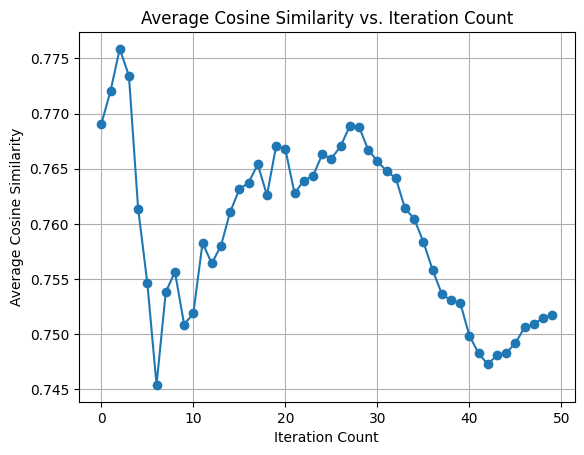

In [54]:
plt.plot(range(len(averages)), averages, marker='o')
plt.xlabel('Iteration Count')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity vs. Iteration Count')
plt.grid(True)
plt.show()

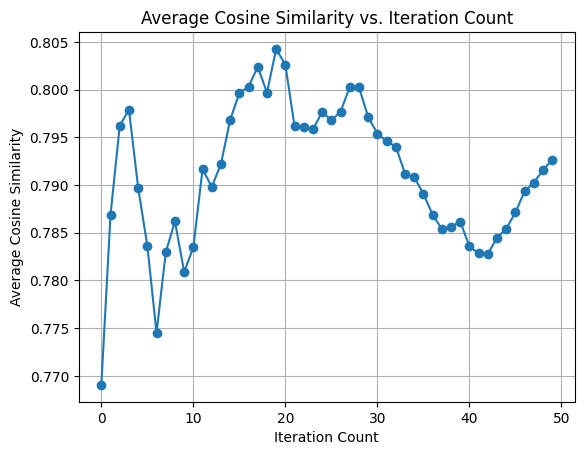

In [55]:
plt.plot(range(len(averages2)), averages2, marker='o')
plt.xlabel('Iteration Count')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity vs. Iteration Count')
plt.grid(True)
plt.show()

In [57]:
import pickle
df_know_embed.to_csv("know-space_withoutFBloop_ConMemNo-gpt4.5.csv")
df_con = pd.DataFrame(concept_space, columns = ['concepts'])
df_con.to_csv("con-space_withoutFBloop_ConMemNo-gpt4.5.csv")
with open('avg_iter_sim_withoutFBloop_ConMemNo-gpt4.5.pkl', 'wb') as file:
    pickle.dump(avg_iteration_sim, file)
with open('sim_list_withoutFBloop_ConMemNo-gpt4.5.pkl', 'wb') as file:
    pickle.dump(similarity_lists, file)

In [58]:
with open('past_transitions_withoutFBloop_ConMemNo-gpt4.5.pkl', 'wb') as file:
    pickle.dump(past_transitions, file)

In [ ]:
def visualize_graph(system):
        """Draws the concept-knowledge transformation graph."""
        plt.figure(figsize=(12, 7))
        pos = nx.spring_layout(system.graph)
        labels = nx.get_edge_attributes(system.graph, "transition")

        nx.draw(system.graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10)
        nx.draw_networkx_edge_labels(system.graph, pos, edge_labels=labels, font_size=9)
        plt.title("Concept-Knowledge Transformation Graph")
        plt.show()